# Baby's First Bayesian Model using PyMC

___

## Set Up

In [1]:
# Import Packages
import arviz as az
# import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from scipy import stats

# Set Seed
np.random.seed(42)

## Simulate Data

Let's say that we have a cat who knocks over my favourite mug of coffee every day. I always diligently clean it up and brew myself another cup immediately and over the course of 14 days I count how often my cat comes and knocks over my mug.

In [2]:
cat_knocks = stats.poisson(mu=4).rvs(14)

cat_knocks

array([5, 4, 4, 4, 2, 5, 2, 5, 3, 5, 7, 1, 4, 3])

I simlated this data by using a `poisson` distribution with a mean of 4. This means that we expect the count of how often my cat knocks over my mug to be a positive integer. 

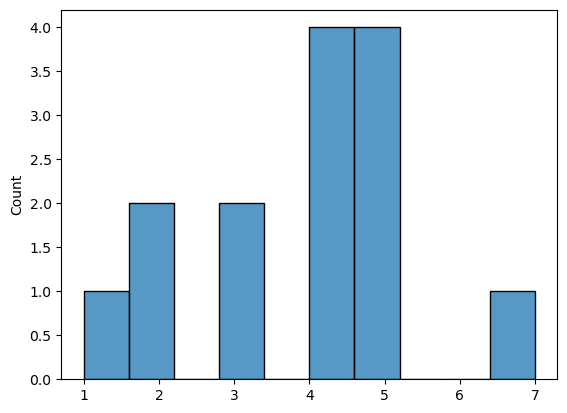

In [3]:
sns.histplot(cat_knocks, bins=10)
plt.show()

We can see that most of the data fits between 2 and 6 times that my cat knocks over my mug of coffee in a day, and sometimes he gets very excited and knocks it over 9 times! 

## Building the Model

Of course, we can build a model using a `poisson` likelihood. However, we want this to be "baby's first model" and so we'll assume that the data are normally distributed because that's easier to think about. 

Note that your likelihood is a part of your model, there is no objectively right answer as to which one you choose. The goal is to get something that describes the data somewhat well. Although it is easier to think about than a `poisson` likelihood, a `normal` likelihood allows for a negative number of times that my cat knocked over my mug. 

There are various ways that you can fix this. For instance, you can choose specific priors or a truncated likelihood that make this outcome impossible. But we'll keep it open for now since this problem with the model won't be a problem for us. 

In [4]:
with pm.Model() as cat_model:
    σ = pm.HalfNormal("σ", sigma=1)
    μ = pm.Normal("μ", mu=7, sigma=1)

    likelihood = pm.Normal("likelihood", mu=μ, sigma=σ, observed=cat_knocks)

In order to build a model we need to create using python's `with` statement. `with pm.Model() as cat_model` creates a PyMC model called `cat_model` and then we define the structure of the model within it. 

As mentioned before, our likelihood is normally distributed with priors for the mean and standard deviation for that model. We'll also pass our data to the model using `observed` parameter.

Let's say that we are very frustrateg with our cat and so we expect that most of the data will be between 5 and 9 without seeing the data and so the mean of our normal distribution will have an average of 7 with a standard deviation of 1. 

Meanwhile, we don't have any specific opinion about how big our standard deviation should be other than it's possible. Which is why I have used a half-normal with a standard deviaion of 1. 

## Prior Predictive Check

Now that we have defined our model, we can see what kind of data it generates and see if it's reasonable given how what we know about our cat and how often he knocks glasses over.

In [5]:
with cat_model:
        prior_pred = pm.sample_prior_predictive(samples=1000)

Sampling: [likelihood, μ, σ]


Once again, we call the model using `with` and we sample a prior predictive simulation.

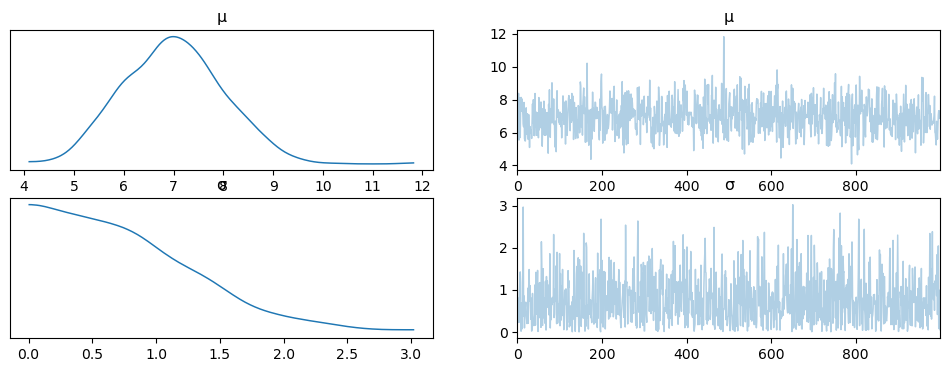

In [6]:
az.plot_trace(prior_pred.prior)
plt.show()

These are the priors that we used to instantiate our data, except plotted. The issue is, what kinds of outcomes do we get from our model? 

In [7]:
prior_pred.prior_predictive.likelihood.squeeze().shape

(1000, 14)

Note that our prior predictive for our likelihood is 1000 samples for each data point. Since our data doesn't change over the data-points we should expect these distributions to look the same.

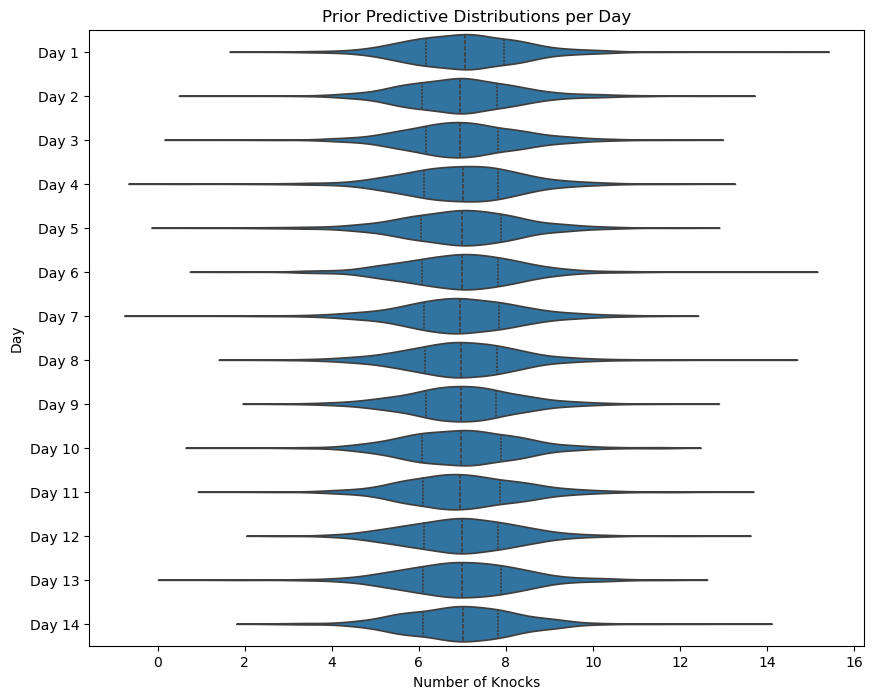

In [8]:
# Prepare the data
samples = prior_pred.prior_predictive.likelihood.squeeze()

df = pd.DataFrame(samples, columns=[f"Day {i+1}" for i in range(samples.shape[1])])
df_long = df.melt(var_name="Day", value_name="Number of Knocks")

plt.figure(figsize=(10, 8))
sns.violinplot(data=df_long, x="Number of Knocks", y="Day", density_norm="width", inner="quartile")
plt.title("Prior Predictive Distributions per Day")
plt.show()


We can see that as I mentioned, it's possible to have a negative number of knocks, but we'll ignore that since we accept that this is going to be one of the ways in which our model is wrong despite still being useful. 

The important thing is that it covers most of the outcomes between 0 and 15, which is a number of knocks that we may expect to see. It's not inappropraitely high so as to have 100s of knocks. 

## Fitting the Model to Data

Now that our model is instantiated, we can try to fit the model.

In [9]:
with cat_model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


There's a lot that just happened under the hood just now. However, until you start writing more complicated models I wouldn't worry about it. Basically, you should rarely need to adjust what's going on under the hood and if you are having difficulty sampling from the distribution then it's because your model needs work.

In the words of Andrew Gelman:

> If your model is having problems then that's usually a problem with your model.

The advice is usually to start with simple models before working up to more complex ones.

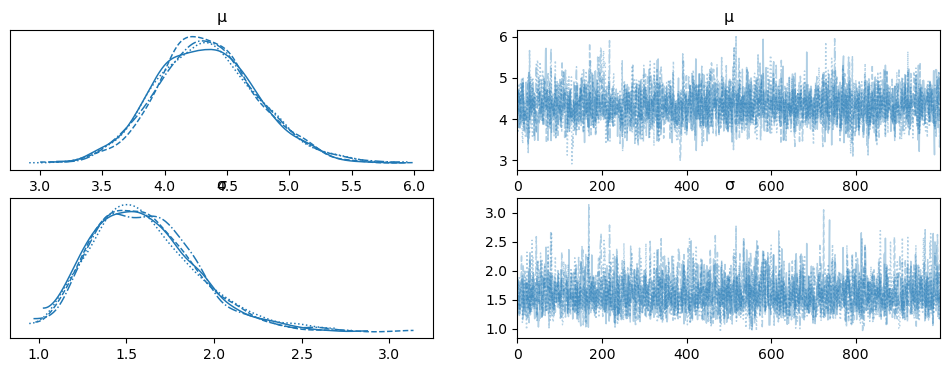

In [10]:
az.plot_trace(trace)
plt.show()

Note that we have multiple distributions here. This is because the model is sampling the parameters using 4 indepdendent chains. The idea being that if you are able to come to the same distribution despite running the algorithm a number of times then that means that your inference is more likely to be robust.

Furthermore, we can see the samples in the trace-plot to the right. We can see that the distribution is being sampled from well, it's not staying too long in one area and it's not wandering in the space either. 

In [11]:
az.summary(trace, round_to=2)[["mean", "ess_bulk", "r_hat"]]

,mean,ess_bulk,r_hat
μ,4.35,2755.03,1.0
σ,1.61,2673.18,1.0


We can also see that the effective sample size, the amount of effective independent draws in the chains, is close to 4000. 

We can also see that R-hat isn't above 1. If all chains are sampling from the same underlying posterior, their estimates should be similar and R-hat will be close to 1.00.

If R-hat is greater than 1, it means the chains are still exploring different regions of the parameter space — a sign that the sampler hasn’t fully converged yet.

Given that this is a simple model, we don't expect anything to really go wrong. But these are some ways to see if your model is having trouble. Note that your model can still fit well and not necessarily be specified well. 

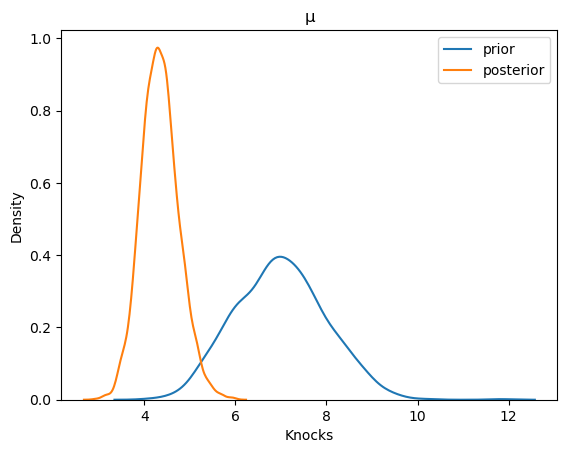

In [12]:
sns.kdeplot(prior_pred.prior.μ.values.squeeze(), label="prior")
sns.kdeplot(trace.posterior.μ.values.reshape(-1), label="posterior")
plt.legend()
plt.title("μ")
plt.xlabel("Knocks")
plt.show()

We can see from this that the number of times my cat knocks over my mug is lower than I expected and so given my prior, the model and the data it should be lower. 

In [13]:
(trace.posterior.μ.values.reshape(-1)[:1000] < prior_pred.prior.μ.values.squeeze()).mean()

0.998

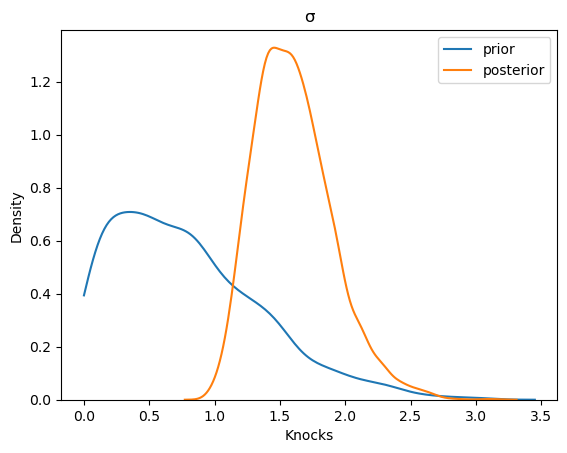

In [14]:
sns.kdeplot(prior_pred.prior.σ.values.squeeze(), label="prior", clip=(0, 10))
sns.kdeplot(trace.posterior.σ.values.reshape(-1), label="posterior", clip=(0, 10))
plt.legend()
plt.title("σ")
plt.xlabel("Knocks")
plt.show()

Meanwhile, there was more variability in the data than we expected. 

## Posterior Predictive Check

Now that we have fit our model, let's take a look at what the posterior predictive distribution looks like. 

In [15]:
with cat_model:
    post_pred = pm.sample_posterior_predictive(trace, random_seed=42)

Sampling: [likelihood]


Output()

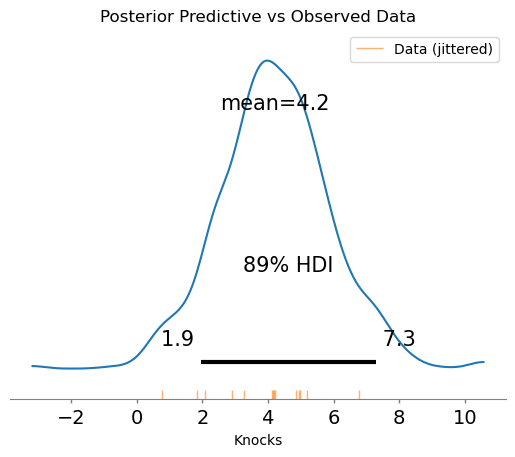

In [16]:
# Add a small amount of random jitter to your observed data
jittered_knocks = cat_knocks + np.random.normal(0, 0.2, size=len(cat_knocks))

az.plot_posterior(post_pred.posterior_predictive.likelihood[0, :, 0],
                  hdi_prob=0.89)
sns.rugplot(jittered_knocks, label="Data (jittered)", alpha=0.6, color=sns.color_palette()[1])

plt.legend()
plt.xlabel("Knocks")
plt.title("Posterior Predictive vs Observed Data")
plt.show()

It seems that the model fits the data somewhat well, but we can also see that the model is still pretty uncertain. Then again, we only have two weeks worth of data. 

It seems that 89% of simualted knocks take place between 1.3 and 7.5, which means that our initial impression that the mean of the distribution was 7 was just too high. In reality, the model estimates that it's closer to 4, which is actually what we programmed the simulated data to have! 


## Some Interesting Statistics

Now that we have our posterior distribution. We can start asking interesting questions of our data. Given the data and the model, what's the probability that the mean of the distribution is less than 7?

In [17]:
(trace.posterior.μ.values.reshape(-1) < 7).mean()

1.0

We can see that it's almost certainly less than 7, I was being too hard on our kitty. 

Note that this is a question about the mean of the distribution, it's not the same as the posterior probability that our cat knocks over our mug less than 7 times.

In [18]:
(post_pred.posterior_predictive.likelihood[0, :, 0].values < 7).mean()

0.944

We can see that the posterior probability of actually seeing our cat knock our mug over less than 7 times is actually 95%.

To be fair, these questions aren't that interesting because the model is so simple, but at least you understand the workflow better.

And that's it! Baby's first Bayesian model.